<a href="https://colab.research.google.com/github/Akiwacky/Linear-Regression-Insurance/blob/main/GH_Linear_Regression_Insurance_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#Problem / Objective: 

Predict / Estimate the insurance costs of indivduals given a few details of theirselves. 

#Get Data

In [1]:
dataset = 'insurance.csv'

In [4]:
df = pd.read_csv(dataset)

## Review Information about the data

In [5]:
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

In [8]:
df.describe(include='O')

sex smoker     region
count   1338   1338       1338
unique     2      2          4
top     male     no  southeast
freq     676   1064        364

## Plot the variables of the data to understand more

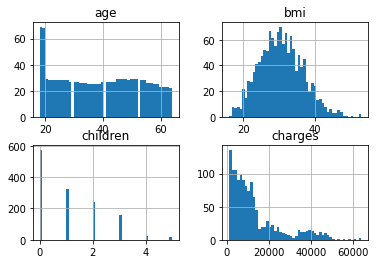

In [9]:
df.hist(bins=50)
plt.show()

From the visualisation, we see age shows a uniform distribution, bmi closely resemebles a normal distruibution while charges has a positively skewed distribtuion. As charges is what we aim to predict, the current distriubtion is not helpful. We can perform a log transmation to to reduce the skewness and bring the data closer to a normal distribution. We must remember to convert it back tho

In [10]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

#Create a Test Set

In [11]:
X_train, x_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.region)

Create a training and test set of the data and strateify based on regions

#Explore the Data

In [12]:
df_copy = df.copy()

In [13]:
df_copy.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

##Log Transformation of the Charges

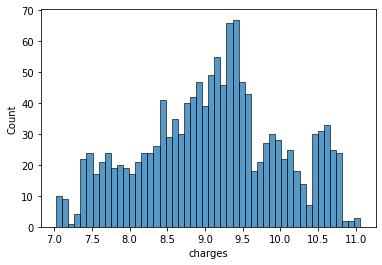

In [14]:
charges_logs = np.log1p(df_copy.charges)
sns.histplot(charges_logs, bins=50)

## Assess correlations between the (numerical) independent variables & response variable

In [15]:
#Check for correlations
corr_matrix = df_copy.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

From the results we see that age, bmi and children bare little correlation to charges

## Assess the Risk Ratio between (categorical) independent variables and the response variable

In [16]:
#Check Risk Ratio 
global_mean = df.charges.mean()
global_mean

13270.422265141257

In [17]:
from IPython.display import display
categorical = ['sex','smoker','region']
for col in categorical:
  df_group = df.groupby(by=col).charges.agg(['mean'])
  df_group['diff'] = df_group['mean'] - global_mean
  df_group['risk'] = df_group['mean'] / global_mean
  display(df_group)

mean        diff      risk
sex                                       
female  12569.578844 -700.843421  0.947188
male    13956.751178  686.328913  1.051719

mean          diff      risk
smoker                                      
no       8434.268298  -4836.153967  0.635569
yes     32050.231832  18779.809566  2.415163

mean         diff      risk
region                                        
northeast  13406.384516   135.962251  1.010246
northwest  12417.575374  -852.846891  0.935733
southeast  14735.411438  1464.989172  1.110395
southwest  12346.937377  -923.484888  0.930410

All but one of the features do not give very interesting insight except for smoking as we see you are 2.4 times likely to pay higher insurance costs if you smoke compared to if you do not. 

#Prepare the data

In [18]:
#Log the target variable 
y_train = np.log1p(X_train.charges)
y_test = np.log1p(x_test.charges)

In [19]:
del X_train['charges']
del x_test['charges']

In [20]:
X_train_dict = X_train.to_dict(orient='records')
X_train_dict[0]

{'age': 51,
 'bmi': 24.415,
 'children': 4,
 'region': 'northwest',
 'sex': 'male',
 'smoker': 'no'}

In [21]:
dv = DictVectorizer(sparse=False)
dv.fit(X_train_dict)

DictVectorizer(sparse=False)

In [22]:
X_train_df = dv.transform(X_train_dict)

In [23]:
dv.get_feature_names_out()

array(['age', 'bmi', 'children', 'region=northeast', 'region=northwest',
       'region=southeast', 'region=southwest', 'sex=female', 'sex=male',
       'smoker=no', 'smoker=yes'], dtype=object)

#ML Model - Linear Regression 

In [24]:
#Create a linear regression object
model = LinearRegression()
model.fit(X_train_df, y_train)

LinearRegression()

In [25]:
#Train the model
model.score(X_train_df, y_train)

0.7634372596598131

In [28]:
#The Coefficients
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

intercept: 7.710948705470939
slope: [ 0.03514822  0.01221976  0.09890681  0.10430533  0.00672282 -0.08809437
 -0.02293378  0.02620756 -0.02620756 -0.78135614  0.78135614]


In [29]:
#Make predicitions using the test set
x_test_dict = x_test.to_dict(orient='records')
x_test_df = dv.transform(x_test_dict)

In [30]:
x = model.predict(x_test_df)

In [37]:
rmse = mean_squared_error(x, y_test, squared=False)
rmse

0.42395527039925324

In [38]:
r2 = r2_score(x, y_test)
r2

0.7397073289342071

# Test the model 

In [47]:
sample = df.sample(1)
sample

age   sex   bmi  children smoker     region   charges
2   28  male  33.0         3     no  southeast  4449.462

In [48]:
test = sample.copy()
del test['charges']
test = test.to_dict(orient='records')
test = dv.transform(test)

In [49]:
test = model.predict(test)

In [50]:
np.expm1(test[0])

4910.88648559159